# Stacked LSTM - Time Serise Dataset

* 서울시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
* https://data.kma.go.kr/cmmn/main.do
* 기후통계분석 -> 기온분석 -> 기간(20110101~20191231) -> 검색 -> CSV 다운로드
* Seoul_Temp.csv

## Import Packages

In [0]:
%tensorflow_version 1.x
import tensorflow as tf

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


# I. Colab File Upload

> ## 1) 'Seoul_temp.csv' 파일을 Colab에 업로드 후 진행

In [0]:
temp = pd.read_csv('Seoul_Temp.csv')

temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


# II. Data Preprocessing

> ## 1) 일일 평균온도('avg') 변화 시각화

* 일일 평균온도 변화에 일정한 패턴 확인

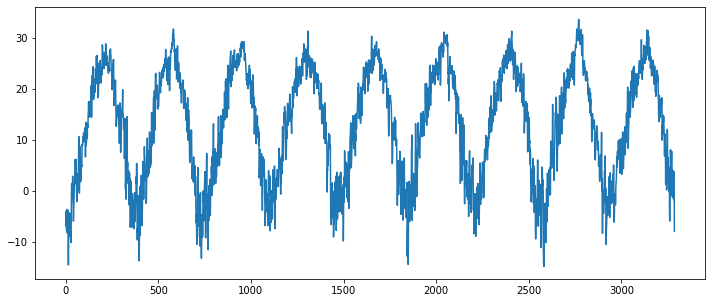

In [0]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

> ## 2) Normalization

* tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [0]:
scaler = MinMaxScaler(feature_range = (-1, 1))

temp_data = scaler.fit_transform(temp_data)

> ## 3) Train vs. Test Split

* Train_Dataset : 2011년 01월 01일 ~ 2017년 12월 31일
* Test_Dataset : 2018년 01월 01일 ~ 2019년 12월 31일

In [0]:
train = temp_data[0:2557]
test  = temp_data[2557:]

# III. 시계열 데이터 처리 함수

> ## 1) 시계열 학습용 데이터 생성 함수 정의

* X : 학습 평균온도 데이터
* y : 정답 평균온도 데이터
* 일정 기간의 X로 y를 예측하도록 학습

In [0]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

> ## 2) loop_back 기간 설정 후 학습데이터 생성

* 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [0]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

> ## 3) Tensor Reshape

In [0]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

# IV. Stacked LSTM Keras Modeling

> ## 1) Model Define

In [0]:
model = Sequential(name = 'Stackd_LSTM')
model.add(LSTM(32, 
               activation='tanh',
               input_shape = (None, 1), 
               return_sequences = True))
model.add(LSTM(32,
               activation='tanh',
               input_shape = (None, 1),
               return_sequences = False))
model.add(Dense(1, activation='tanh'))

* Model Summary

In [0]:
model.summary()

Model: "Stackd_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 32)          4352      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile

In [0]:
model.compile(loss = 'mean_squared_error', 
              optimizer='adam')

> ## 3) Model Fit
* 약 30분

In [0]:
hist = model.fit(train_X, train_y,
                 epochs = 50, 
                 batch_size = 16,  
                 validation_data = (test_X, test_y))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2377 samples, validate on 550 samples
Epoch 1/50





2377/2377 [==============================] - 36s 15ms/step - loss: 0.0294 - val_loss: 0.0166
Epoch 2/50
2377/2377 [==============================] - 34s 15ms/step - loss: 0.0183 - val_loss: 0.0181
Epoch 3/50
2377/2377 [==============================] - 34s 14ms/step - loss: 0.0174 - val_loss: 0.0158
Epoch 4/50
2377/2377 [==============================] - 35s 15ms/step - loss: 0.0163 - val_loss: 0.0146
Epoch 5/50
2377/2377 [==============================] - 35s 15ms/step - loss: 0.0153 - val_loss: 0.0129
Epoch 6/50
2377/2377 [==============================] - 34s 14ms/step - loss: 0.0142 - val_loss: 0.0122
Epoch 7/50
2377/2377 [==============================] - 34s 14ms/step - loss: 0.0130 - val_loss: 0.0112
Epoch 8/50
2377/2377 [==============================] - 35s 15ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 9/50
2377/237

> ## 4) 학습결과 시각화

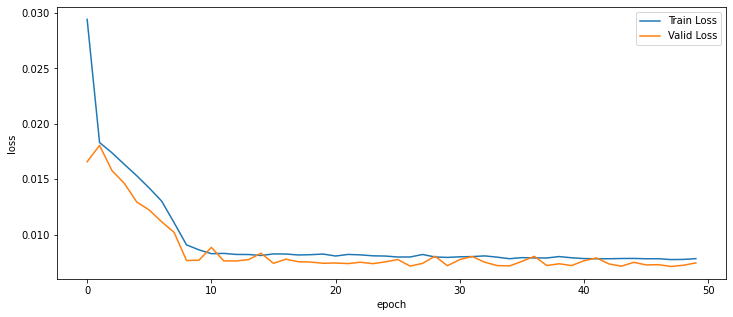

In [0]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper right')
plt.show()

> ## 5) Model Evaluate

In [0]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  0.0076908219157458355
Test Score:  0.007459772222421386


# V. Model Predict

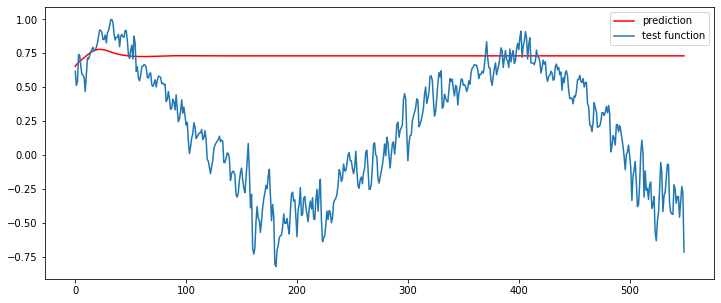

In [0]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
    
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = "prediction")
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = "test function")
plt.legend()
plt.show()

# 
# 
# 
# The End
# 
# 
# 